In [ ]:
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
from scvi.dataset import AnnDatasetFromAnnData
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scvi.models.vae import VAE
import numpy as np
import surgeon

In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas Celseq', 'Pancreas CelSeq2', 'Pancreas SS2']

In [4]:
adata = sc.read("data/pancreas/pancreas_count.h5ad")
adata = adata[adata.obs[condition_key].isin(target_conditions)]
adata

View of AnnData object with n_obs × n_vars = 6714 × 15369 
    obs: 'batch', 'study', 'cell_type'

In [5]:
adata_normalized = adata.copy()

In [6]:
adata_normalized = surgeon.utils.normalize(adata_normalized,
                                           filter_min_counts=False,
                                           normalize_input=False,
                                           logtrans_input=True,
                                           size_factors=True,
                                           n_top_genes=2000)

In [7]:
adata_normalized

AnnData object with n_obs × n_vars = 6714 × 2000 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [8]:
adata = adata[:, adata_normalized.var_names]
adata

View of AnnData object with n_obs × n_vars = 6714 × 2000 
    obs: 'batch', 'study', 'cell_type'

In [9]:
adata.X.min(), adata.X.max()

(0.0, 1341375.0)

In [10]:
adata.obs.groupby([cell_type_key, condition_key]).size()

cell_type                 study           
Pancreas Acinar           Pancreas CelSeq2     170
                          Pancreas Celseq      162
                          Pancreas SS2         103
Pancreas Alpha            Pancreas CelSeq2     885
                          Pancreas Celseq      220
                          Pancreas SS2        1109
Pancreas Beta             Pancreas CelSeq2     571
                          Pancreas Celseq      279
                          Pancreas SS2         765
Pancreas Beta(ER stress)  Pancreas CelSeq2      29
                          Pancreas Celseq       62
                          Pancreas SS2          31
Pancreas Delta            Pancreas CelSeq2     199
                          Pancreas Celseq       66
                          Pancreas SS2         142
Pancreas Ductal           Pancreas CelSeq2     315
                          Pancreas Celseq      402
                          Pancreas SS2         462
Pancreas Endothelial      Pancreas CelS

In [11]:
adata.obs['labels'] = LabelEncoder().fit_transform(adata.obs[cell_type_key])
adata.obs['batch_indices'] = LabelEncoder().fit_transform(adata.obs[condition_key])

Trying to set attribute `.obs` of view, making a copy.


In [12]:
adata.obs['labels'].value_counts()

1    2214
2    1615
5    1179
0     435
4     407
7     365
8     186
6     135
3     122
9      56
Name: labels, dtype: int64

In [13]:
adata.obs['batch_indices'].value_counts()

2    2989
0    2449
1    1276
Name: batch_indices, dtype: int64

In [14]:
scvi_adata = AnnDatasetFromAnnData(adata)
scvi_adata

[2019-09-04 14:22:28,932] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2019-09-04 14:22:28,970] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-09-04 14:22:28,971] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-09-04 14:22:28,991] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-09-04 14:22:29,000] INFO - scvi.dataset.dataset | Downsampled from 6714 to 6714 cells


GeneExpressionDataset object with n_cells x nb_genes = 6714 x 2000
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'labels', 'batch_indices', 'local_means', 'local_vars'
    cell_categorical_attribute_names: 'labels', 'batch_indices'

In [15]:
scvi_adata.n_labels, scvi_adata.n_batches

(10, 3)

In [17]:
np.unique(scvi_adata.batch_indices)

array([0, 1, 2], dtype=uint16)

In [18]:
np.unique(scvi_adata.labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint16)

## Creating the Model

In [19]:
n_epochs = 300
lr = 1e-3
use_batches = True
n_samples = adata.shape[0]

In [24]:
vae = VAE(scvi_adata.nb_genes, n_batch=scvi_adata.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    vae,
    scvi_adata,
    train_size=0.8,
    use_cuda=True,
    frequency=1,
)

In [25]:
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 300/300 [01:59<00:00,  2.43it/s]


In [26]:
trainer.train_set.reconstruction_error()

1719.7763393688326

In [27]:
trainer.history.keys()

dict_keys(['elbo_train_set', 'elbo_test_set'])

In [28]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]

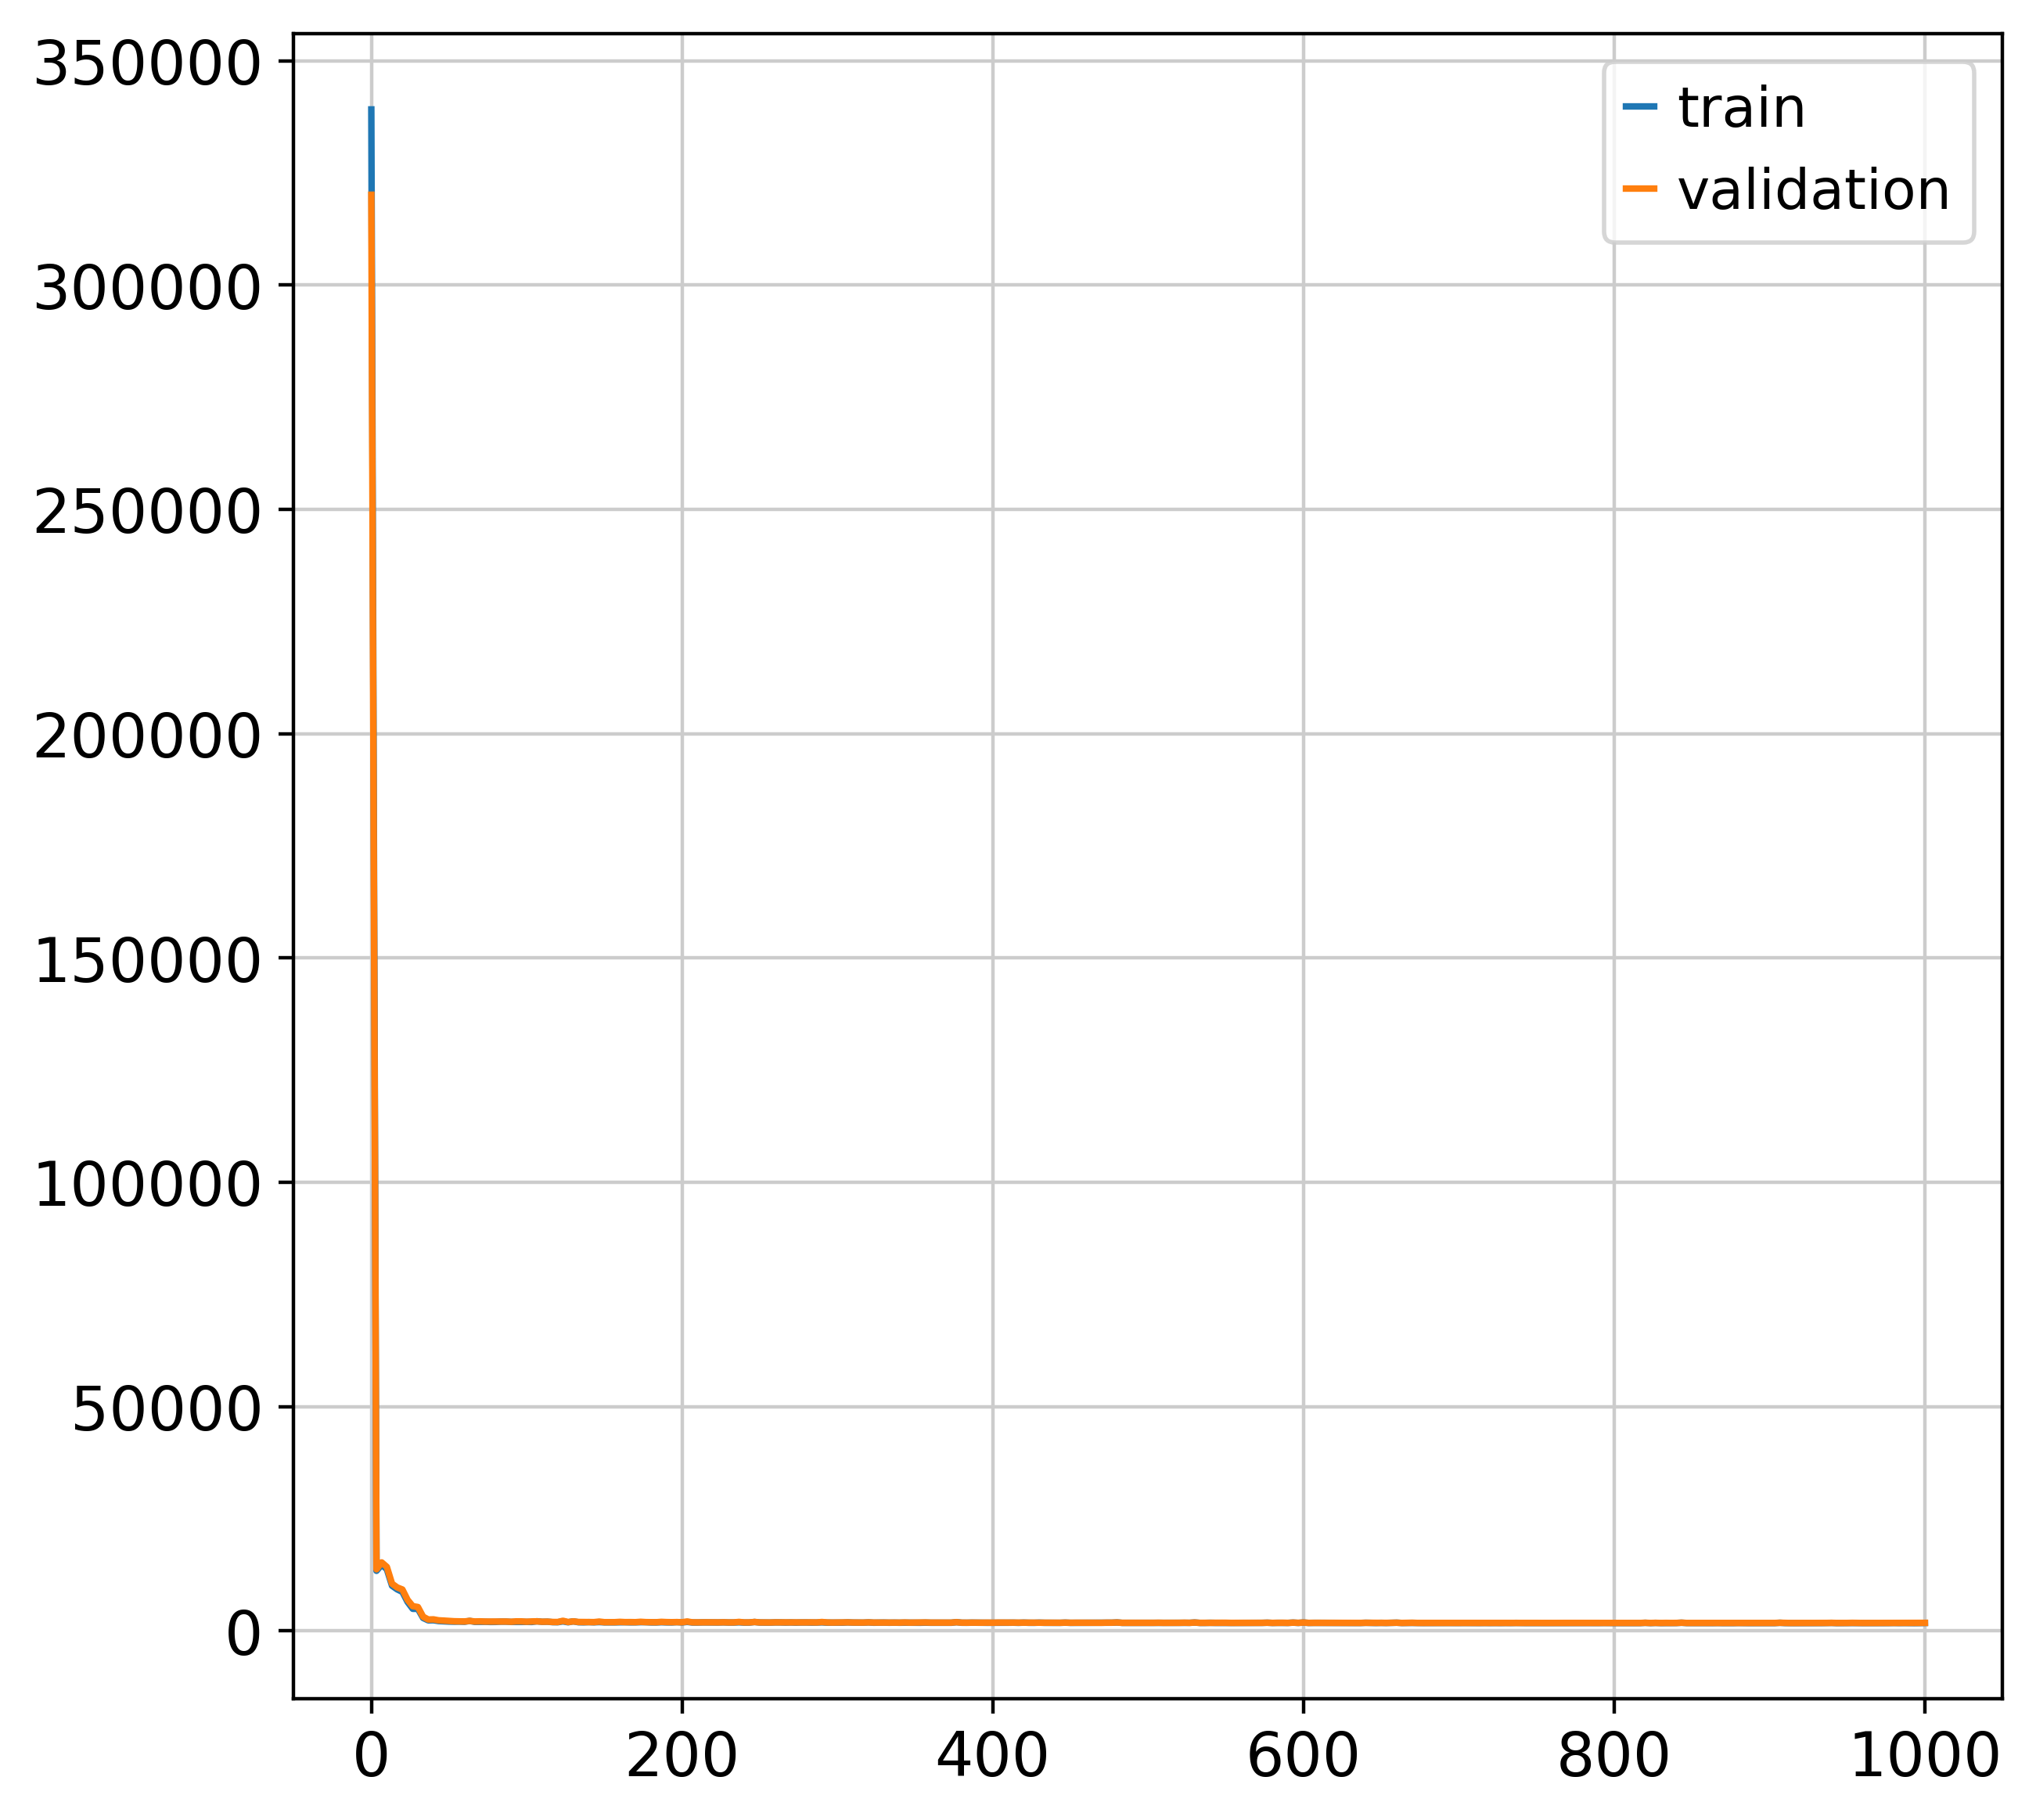

In [29]:
x = np.linspace(0, 1000, (len(elbo_train_set)))
plt.close("all")
plt.figure(figsize=(7, 7))
plt.plot(x, elbo_train_set, label='train')
plt.plot(x, elbo_test_set, label='validation')
plt.legend()
plt.show()

In [30]:
le = LabelEncoder()
le.fit(target_conditions)
le.classes_

array(['Pancreas CelSeq2', 'Pancreas Celseq', 'Pancreas SS2'],
      dtype='<U16')

In [33]:
posterior = trainer.create_posterior(trainer.model, scvi_adata, indices=np.arange(len(scvi_adata)))

In [34]:
latent, batch_indices, labels = posterior.sequential().get_latent()

In [35]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
np.unique(batch_indices)

array([0, 1, 2])

In [47]:
latent_adata = sc.AnnData(latent)
latent_adata.obs[cell_type_key] = adata.obs[cell_type_key].values
latent_adata.obs[condition_key] = adata.obs[condition_key].values
latent_adata

AnnData object with n_obs × n_vars = 6714 × 10 
    obs: 'cell_type', 'study'

In [48]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

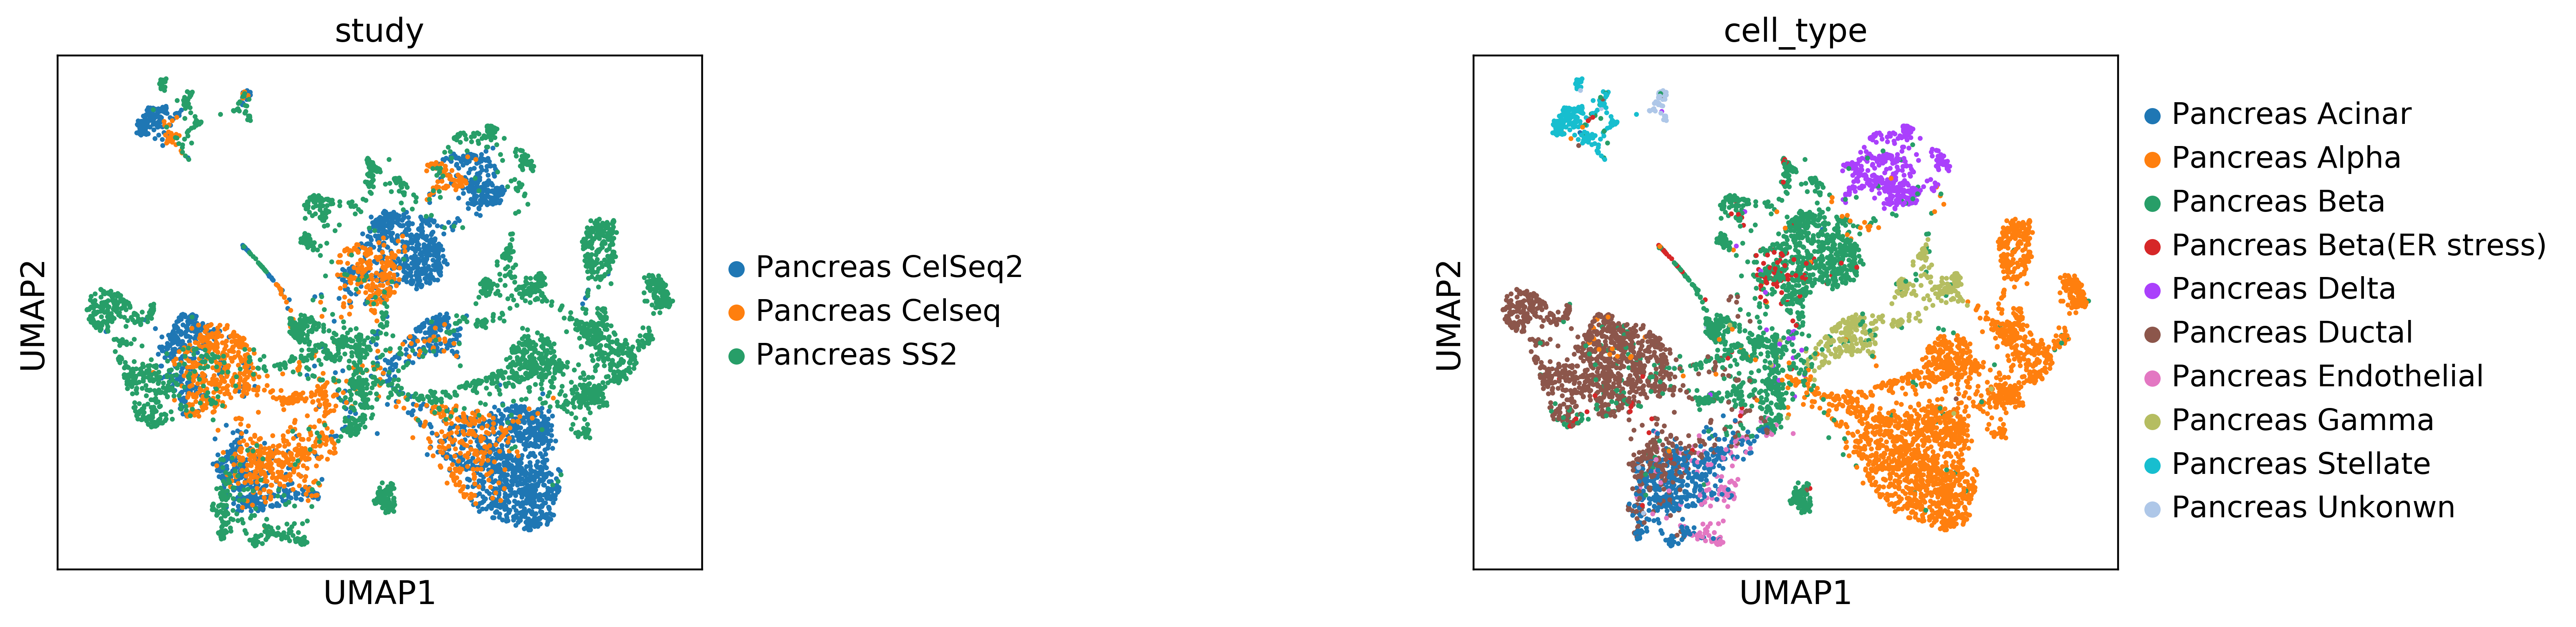

In [49]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=1.0)

In [50]:
surgeon.metrics.ari(latent_adata, cell_type_key)

0.5514549002178407

In [51]:
surgeon.metrics.nmi(latent_adata, cell_type_key)

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.6687350202847699